In [17]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
## import xgboost
import math
import matplotlib
from __future__ import division
from time import time
import seaborn as sns; sns.set(style="ticks", color_codes=True)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn import cross_validation, tree, linear_model
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import ShuffleSplit
from sklearn.metrics import explained_variance_score
import sklearn.learning_curve as curves
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

import os



C:\Users\yuhao\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\yuhao\Anaconda3\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [ ]:
dataset = pd.read_csv("train.csv", names=['Store','Dept','Date','weeklySales','isHoliday'],sep=',', header=0)
features = pd.read_csv("features.csv",sep=',', header=0,
                       names=['Store','Date','Temperature','Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4',
                              'MarkDown5','CPI','Unemployment','IsHoliday']).drop(columns=['IsHoliday'])
stores = pd.read_csv("stores.csv", names=['Store','Type','Size'],sep=',', header=0)
dataset = dataset.merge(stores, how='left').merge(features, how='left')

data= dataset.iloc[:,[0,1,2,3,4,5,6,7,8,14,15]]
data.head()

dataset.head()

In [24]:
features = dataset.iloc[:,[0,1,2,3,6,7,8,14,15]].columns.tolist()
target = dataset.iloc[:,4].name
target1 = dataset.iloc[:,5].name

In [33]:
correlations = {}
for f in features:
    data_temp = dataset[[f,target]]
    x1 = data_temp[f].values
    x2 = data_temp[target].values
    key = f + ' vs ' + target
    correlations[key] = pearsonr(x1,x2)[0]

correlations1 = {}
for f in features:
    data_temp1 = dataset[[f,target1]]
    x3 = data_temp1[f].values
    x4 = data_temp1[target1].values
    key1 = f + ' vs ' + target1
    correlations1[key1] = pearsonr(x3,x4)[0]
    
data_correlations = pd.DataFrame(correlations, index=['Value']).T
data_correlations.loc[data_correlations['Value'].abs().sort_values(ascending=False).index]

data_correlations1 = pd.DataFrame(correlations1, index=['Value']).T
data_correlations1.loc[data_correlations1['Value'].abs().sort_values(ascending=False).index]

TypeError: unsupported operand type(s) for /: 'str' and 'int'

In [ ]:
smaller_frame=dataset[['Store','Dept','Date','weeklySales','isHoliday','Temperature','Fuel_Price','CPI','Unemployment','Type','Size']]
from pandas.tools.plotting import scatter_matrix
al=scatter_matrix(sf, alpha=0.8, figsize=(12, 12), diagonal="kde")
for a in al.flatten():
    a.grid(False)

In [ ]:
smaller_frame.corr()

In [25]:
def scatter(dataset, column):
    plt.figure()
    plt.scatter(dataset[column] , dataset['weeklySales'])
    plt.ylabel('weeklySales')
    plt.xlabel(column)

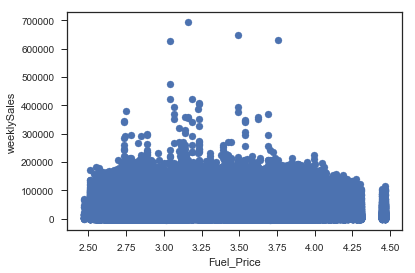

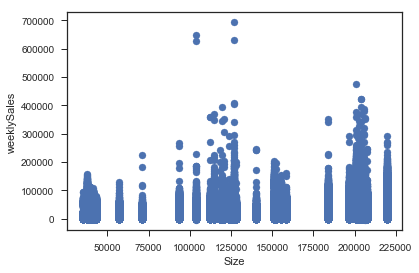

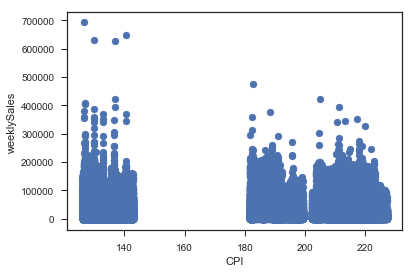

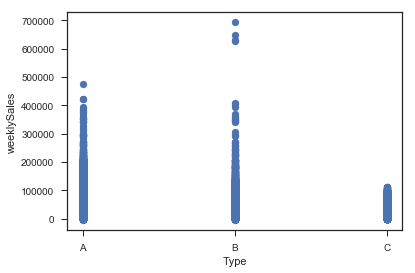

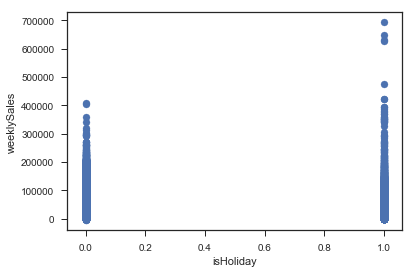

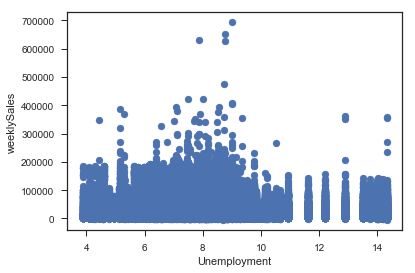

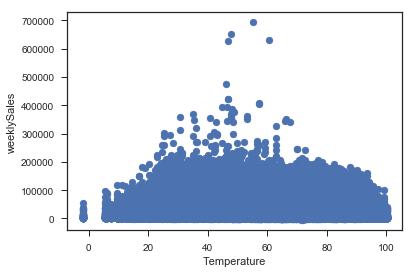

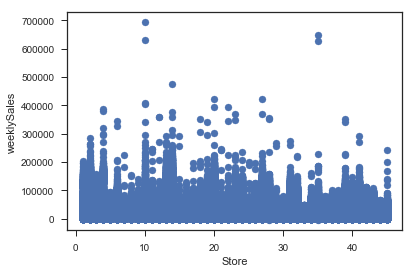

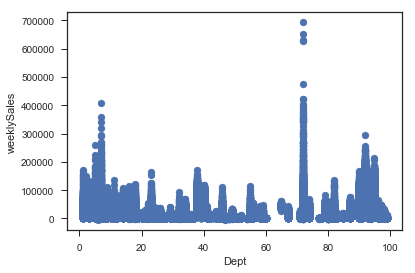

In [7]:
scatter(dataset, 'Fuel_Price')
scatter(dataset, 'Size')
scatter(dataset, 'CPI')
scatter(dataset, 'Type')
scatter(dataset, 'isHoliday')
scatter(dataset, 'Unemployment')
scatter(dataset, 'Temperature')
scatter(dataset, 'Store')
scatter(dataset, 'Dept')

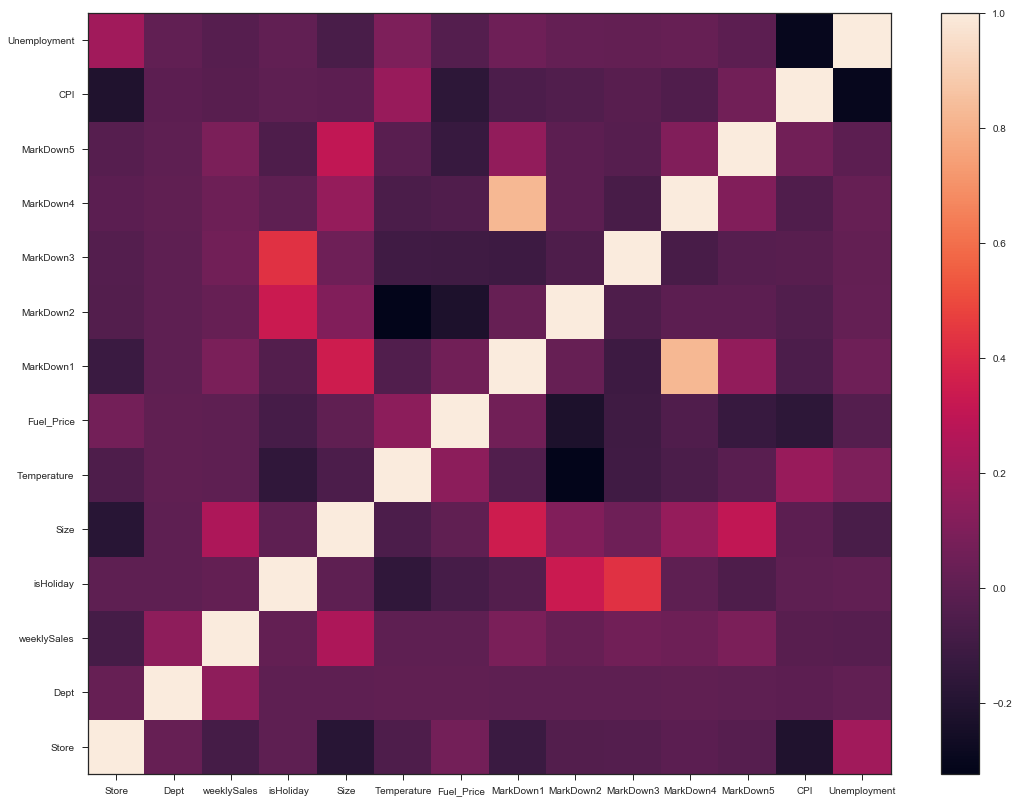

In [8]:
fig = plt.figure(figsize=(18, 14))
corr = dataset.corr()
c = plt.pcolor(corr)
plt.yticks(np.arange(0.5, len(corr.index), 1), corr.index)
plt.xticks(np.arange(0.5, len(corr.columns), 1), corr.columns)
fig.colorbar(c)

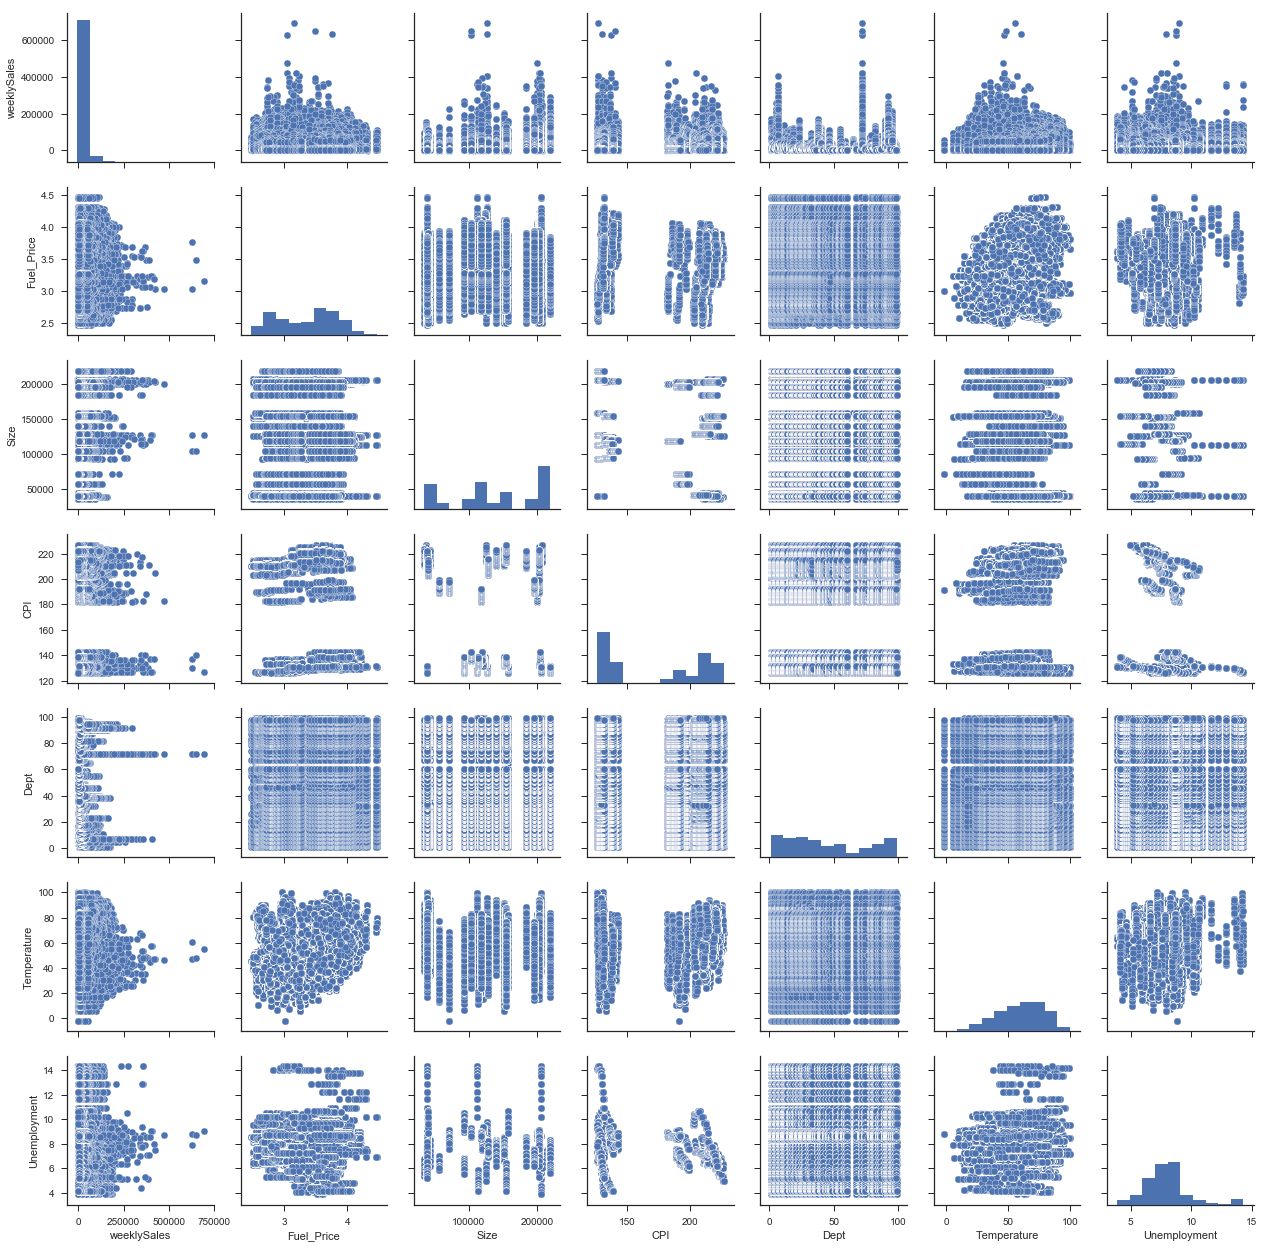

In [12]:
sns.pairplot(dataset, vars=['weeklySales', 'Fuel_Price', 'Size', 'CPI', 'Dept', 'Temperature', 'Unemployment'])

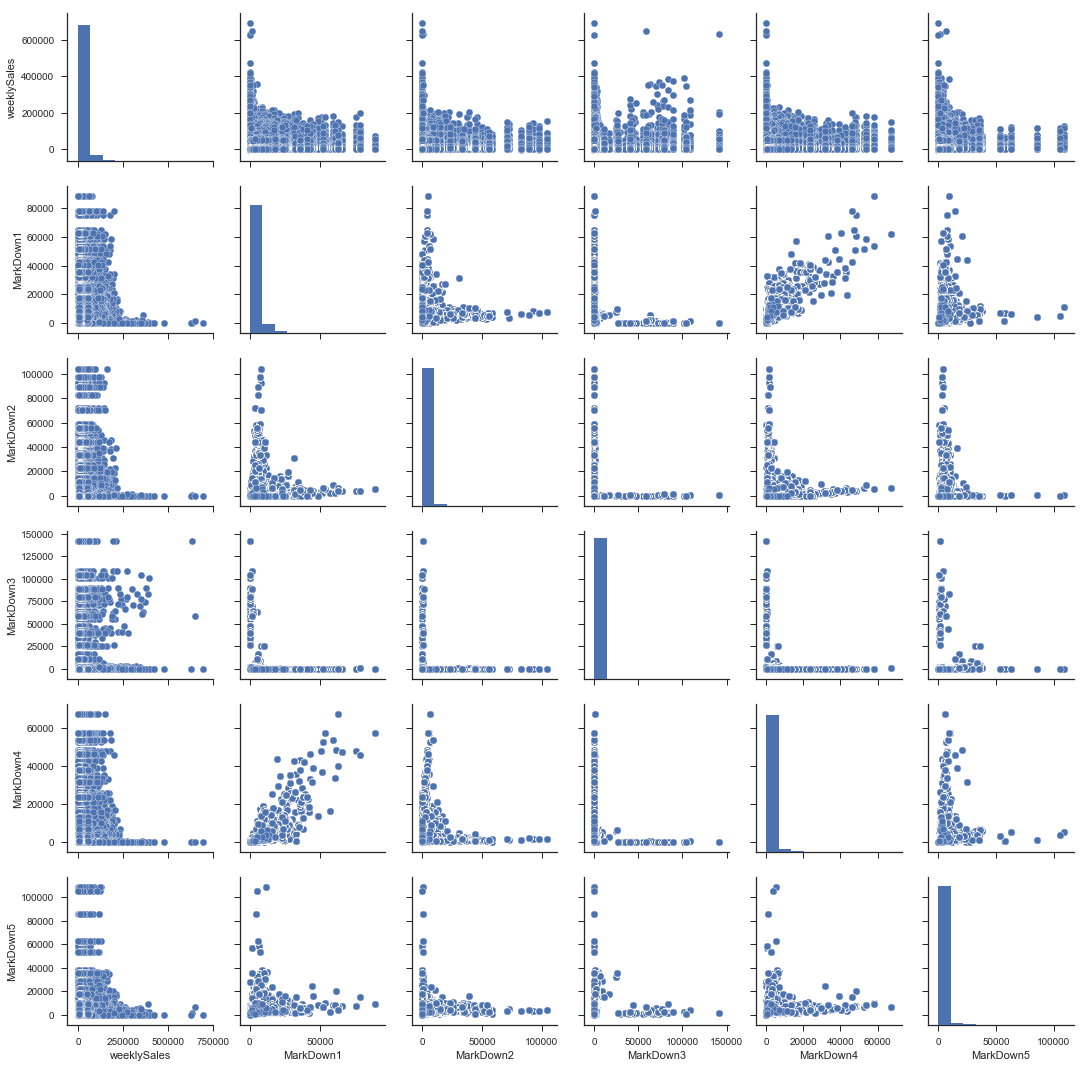

In [13]:
sns.pairplot(dataset.fillna(0), vars=['weeklySales', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'])

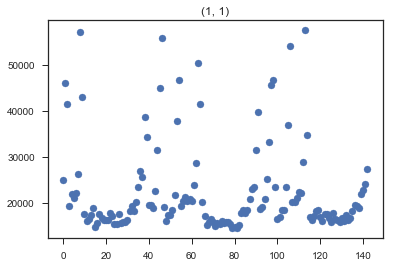

In [14]:
for name, group in dataset.groupby(["Store", "Dept"]):
    plt.title(name)
    plt.scatter(range(len(group)), group["weeklySales"])
    plt.show()
    break

In [ ]:
sns.pairplot(dataset, vars=['weeklySales', 'Fuel_Price', 'Size', 'CPI', 'Dept', 'Temperature', 'Unemployment'])

In [27]:
dataset.head()

,Store,Dept,Date,weeklySales,isHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106


In [ ]:
var = 'bedrooms'
data = pd.concat([df_train['weeklySales'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(14, 6))
fig = sns.violinplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=3500000);

In [ ]:
var = 'bathrooms'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(20, 20))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=3500000);

In [ ]:
var = 'floors'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(20, 20))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=3500000);